# Applying dimensional reduction techniques to data
This notebook is intended to guide you through applying t-SNE and UMAP to the dataset of your choice, ideally formatted as indicated in the README (columns are observables, rows are sample points). 


## Requirements
Because nothing comes without effort...

#### General
pandas >= 0.24.0, otherwise you might not be able to open DataFrames pickled by someone with a recent pandas version. 

In case you are having some problems with dependencies, it might be a good idea to:

1. Create and activate a virtual environment, so the updates you might need to do will not mess up your research project's code.

    1.1 If you don't know how to do this, see the explanation on that page (for conda): https://uoa-eresearch.github.io/eresearch-cookbook/recipe/2014/11/20/conda/ and https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html
    
    1.2 You will also need to configure the environment as a kernel for jupyter notebooks: https://anbasile.github.io/programming/2017/06/25/jupyter-venv/
    
    1.3 If you want to install a package only to the virtual environment, you need to specify it with the `-n` option:  `conda install -n yourenvname [package]`. 
    
    1.4 However, the `conda update` command will update the package version in the current virtual environment; no need to specify it. 
    

2. Run `conda update --all`: update all packages in the virtual environment, to be sure that you won't encounter dependency conflicts. 

#### t-SNE
scikit-learn has a user-friendly but slow implementation of t-SNE. I preferred to use Multicore-TSNE, which has the same interface as scikit-learn's version, but is seemingly the fastest implementation available:

https://github.com/DmitryUlyanov/Multicore-TSNE

You will need to install it with `pip` (it is not available with `conda`):

`pip install Multicore-TSNE`

It will very probably not work, telling you that the package `cmake` was not found. Try to install it with `pip`:

`pip install cmake` 

or with `conda`, if you prefer:

`conda install cmake` 

Then, you should be able to install Multicore-TSNE; if not, try to solve the error messages that you receive.

The commands are supposed to be the same as scikit-learn's TSNE. One downside of that implementation is that it can only produce 2D projections. 

#### UMAP

I think that the only trustworthy implementation is the original one. According to the documentation on Github, you can install via `conda`:

`conda install -c conda-forge umap-learn`

or `pip`:

`pip install umap-learn` 

I have used the pip install, since the conda-forge one wanted to update some packages to versions currently in development (later versions that the regular conda ones). 

There are some dependencies that you may need to install/update: 

conda update numpy scipy
conda update scikit-learn
conda update numba

## References for theory

#### t-SNE
t-SNE's original paper is quite straightforward to understand the algorithm (sections 2-3):

Van Der Maaten L., and Hinton G. “Visualizing Data Using T-SNE.” *Journal of Machine Learning Research*, 9 (2008), 2579–2625.
https://lvdmaaten.github.io/tsne/

Fast implementations use the Barnes-Hut version of t-SNE. Barnes-Hut is essentially an algorithm to compute the gradient approximately and speed up the optimization procedure. 

Documentation of the main function is the same as for the scikit-learn implementation: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html, except that n_component is fixed to be 2. 

#### UMAP
The original paper is much more mathematically heavy than for t-SNE. 

McInnes, Leland, John Healy, and James Melville. “UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction.” *ArXiv*:1802.03426 [Cs, Stat], February 9, 2018. http://arxiv.org/abs/1802.03426.
https://github.com/lmcinnes/umap

Section 2 presents the foundations of the technique in topology and category theory. Section 3 is more practical. 


<!--the central idea is to assume that all points are uniformly distributed on some manifold, 
% then find the Riemannian metric on that manifold which enforces that uniformity property. (not sure about that part yet)
-->

Documentation of the package: https://umap-learn.readthedocs.io/en/latest/parameters.html


In [1]:
# Initial imports
import numpy as np
import pandas as pd
import scipy as sp
import os
from multiprocessing import cpu_count
from matplotlib import pyplot as plt

# Things you will probably need to install
from MulticoreTSNE import MulticoreTSNE as tsne
from umap import UMAP

# Modules from this project
from format_tools import load_object, save_object
from analyze_tools import list_available, load_chosen

In [2]:
# Plot parameters, so graphs look nicer
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["lines.linewidth"] = 3.
plt.rcParams["font.size"] = 14.
plt.rcParams["axes.labelsize"] = 16.
plt.rcParams["legend.fontsize"] = 14.
plt.rcParams["xtick.labelsize"] = 14.
plt.rcParams["ytick.labelsize"] = 14.


## Import your data
Load any pickled DataFrame (or another data format if you feel daring, but there are no guarantees then). 

In [3]:
# Select the folder containing your data files
folder = "data"

# Filter files in the folder by applying the following function on each found file name. 
# Here, we only keep pickle files
condition = lambda x: x.endswith(".pkl")

# Get all files in the chosen folder; store them in a dictionary for easy access
available_files = list_available(folder, condition)

The current working directory is  /Users/francoisb/code_repos/tsne_umap_day
There are 2 available .pkl files in data: {
	0:"gas_example_blocks_formatted.pkl"
	1:"gas_example_ndarray_formatted.pkl"
}
Now, select your file in the cell below


In [4]:
# Choose the file in the dictionary above
file_chosen_index = 1

# Load the object, which should be a DataFrame in this context
df = load_chosen(file_chosen_index, folder, available_files)

Will try to import:
data/gas_example_ndarray_formatted.pkl

Succesfully loaded the following object: 

Observables                   vx   vy   vz    x    y    z
Effect Pressure Temperature                              
burst  0 atm    10 C           0    1    2    3    4    5
                20 C          30   31   32   33   34   35
                30 C          60   61   62   63   64   65
                40 C          90   91   92   93   94   95
crush  3 atm    10 C          18   19   20   21   22   23
                20 C          48   49   50   51   52   53
                30 C          78   79   80   81   82   83
                40 C         108  109  110  111  112  113
       4 atm    10 C          24   25   26   27   28   29
                20 C          54   55   56   57   58   59
                30 C          84   85   86   87   88   89
                40 C         114  115  116  117  118  119
faint  2 atm    10 C          12   13   14   15   16   17
                20 C       

## Apply t-SNE on the loaded data
Skip this section if you prefer UMAP. 

In [12]:
# Create an instance of a t-SNE processor.  Choose a seed for reproducibility
seed = 9901847
number_cpus = cpu_count()  # change this if you don't want to use all your CPUs

# Make sure the DataFrame is dense
df = df.to_dense()

# Hyperparameters for t-SNE (here, default sklearn values are used)
projector_tsne = tsne(n_jobs=number_cpus, random_state=seed, 
    perplexity=30, # controls number of nearest-neighbors, use value between 5 and 50
    early_exaggeration=12.0,  # For larger values, the space between natural clusters will be larger in the embedded space.
    learning_rate=200.0,  # too high or too low: all datapoints will be bunched together.
)

y = projector_tsne.fit_transform(df.values)
print(y.shape)

(20, 2)


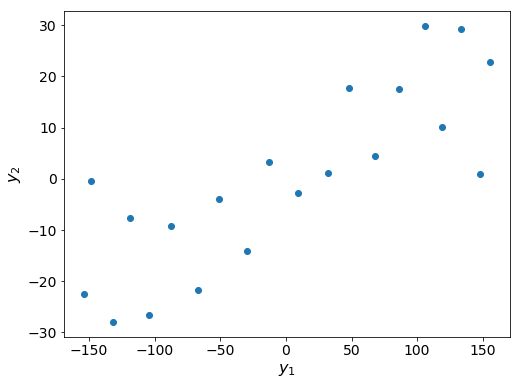

In [13]:
# Plot the resulting projection
fig, ax = plt.subplots()

ax.scatter(y[:, 0], y[:, 1])
ax.set_xlabel(r"$y_1$")
ax.set_ylabel(r"$y_2$")

plt.show()

## Apply UMAP on the loaded data

In [15]:
# Create an instance of a UMAP processor. Choose a seed for reproducibility. 
seed = 9901847

# Make sure the DataFrame is dense
df = df.to_dense()

# Hyperparameters for UMAP (here, default values)
projector_umap = UMAP(random_state=seed, 
    n_neighbors=15,  # balances local (low n_neighbors) vs global structure (high)
    min_dist=0.1,  # minimum distance apart that points are allowed to be in the representation. Use between 0 and 1
    n_components=2,  # Number of final dimensions
    metric="euclidean"  # how distance is computed in the ambient space of the input data
)
# Many choices for metric, see the documentation: https://umap-learn.readthedocs.io/en/latest/parameters.html

y = projector_umap.fit_transform(df.values)
print(y.shape)

(20, 2)


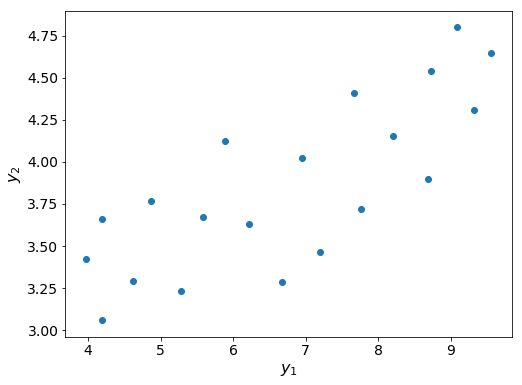

In [16]:
# Plot the resulting projection
fig, ax = plt.subplots()

ax.scatter(y[:, 0], y[:, 1])
ax.set_xlabel(r"$y_1$")
ax.set_ylabel(r"$y_2$")

plt.show()